## Машинное обучение

## Домашнее задание 3


### О задании

Ниже даны несколько заданий. Первые два из них самодостаточные, они позволяют лучше познакомиться с логистической регрессией и ROC-кривой. Далее 3 задания выполняются на реальном наборе данных: вам предлагается настроить логистическую регрессию на них, измерить различные метрики качества, попробовать закодировать категориальные признаки и посмотреть на изменение качества предсказаний. Также в последнем задании предлагается самостоятельно разобраться с методами калибровки вероятностей. 

В каждом задании указано число баллов. Почти все задание основано на использовании готовых методов из sklearn и анализе результатов их работы.

In [1]:
%pylab inline
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


### Задание 1. Обучение логистической регресии на синтетических данных. (2 балла)

Сгенерируйте синтетический датасет для бинарной классификации с помощью `make_classification` с 2 признаками, обучите на нём логистическую регресию. Визуализируйте разделяющую прямую и все объекты. Из иллюстрации должно быть понятно, к какому классу принадлежит объект, и к какому классу его отнесла регресия (это удобно демонстрировать заливкой цветом). 

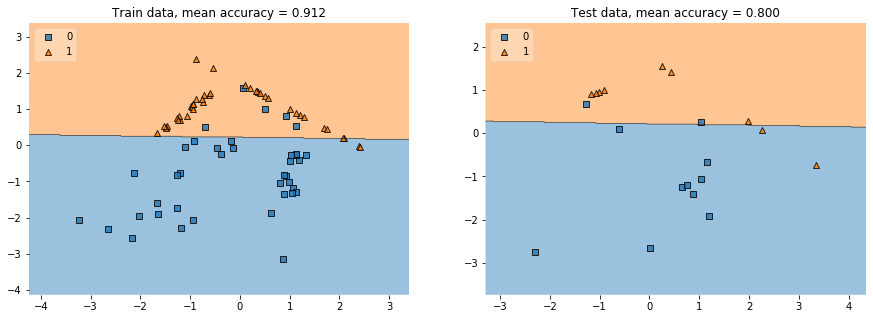

In [2]:
# Если нет mlxtend (для визуализации только понадобится):
# !pip install mlxtend

def get_line(x_train, df=True):
    
    '''
    return: возвращает массив с точками, характеризующий классификатор на плоскости (x1, x2)
    '''
    if df:
        return (- reg.intercept_ - reg.coef_[0][0] * x_train[:, 0]) / reg.coef_[0][1] 
    return (- reg.intercept_ - reg.coef_[0][0] * x_train) / reg.coef_[0][1] 

# Гененрируем данные
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0)

# Разбиваем выборку на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Обучаем логистическую регрессию
reg = LogisticRegression(random_state=0, solver='saga', multi_class='ovr').fit(X_train, y_train)

# Визуализируем полученную регрессию
def get_visual(clf=reg, cool=False):
    '''
    params: clf - классификатор
    cool: boolean - красиво визуализировать или некрасиво
    ---
    return: plot
    '''
    if cool ==False:
        # Если выбрали некрасивую визуализацию, то создаем сабплот из двух графиков
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5));
        
        # Рисуем точечную диаграмму для двух признаков и раскрашиваем их согласно классам
        ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
        # Добавляем линию классификатора
        ax1.plot(X_train[:, 0], get_line(X_train))
        ax1.set_title('Train data, mean accuracy = {:.3f}'.format(reg.score(X_train, y_train)))
        ax1.set_xlabel('X1')
        ax1.set_ylabel('X2')
        
        # Аналогично для второго классификатора: строим диаграмму двух признаков и раскрашиваем
        ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test);
        # Добавляем линию классификатора
        ax2.plot(X_test[:, 0], get_line(X_test))
        ax2.set_title('Test data, mean accuracy = {:.3f}'.format(reg.score(X_test, y_test)))
        ax2.set_xlabel('X1')
        ax2.set_ylabel('X2');
    if cool:
        # Импортируем то, без чего красиво не получится (по крайней мере у меня)
        from mlxtend.plotting import plot_decision_regions
        
        # Разбиваем на два графика
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        # Вызываем нашу визуализацию для тренировочных данных
        plot_decision_regions(X_train, y_train, clf=reg, legend=2, ax=ax1)
        ax1.set_title('Train data, mean accuracy = {:.3f}'.format(reg.score(X_train, y_train)))
        # Вызываем нашу визуализацию для тестовых данных
        plot_decision_regions(X_test, y_test, clf=reg, legend=2, ax=ax2)
        ax2.set_title('Test data, mean accuracy = {:.3f}'.format(reg.score(X_test, y_test)))

# Визуализируем, либо используя стороннюю библиотеку (параметр cool=True), либо мою имплементацию
get_visual(reg, cool=True)

### Задание 2. Самостоятельная реализация вычисления AUC ROC. (3 балла)

Напишите функцию, которая берет на вход `numpy`-вектор правильных ответов `y` (из 0 и 1) и `numpy`-вектор вещественных предсказаний классификатора (длина обоих векторов равна числу объектов) и возвращает значение AUC ROC. Как обычно, можно пользоваться только средствами `numpy` :) Считайте, что в векторе `score_predicted` все элементы различны.

In [3]:
data = X_train @ reg.coef_.T + reg.intercept_
score = data.reshape(-1,)

def _binary_clf_curve(y_true, y_score):
    # Взял функцию с интеренета, соурс указан ниже
    """
    src: http://ethen8181.github.io/machine-learning/model_selection/auc/auc.html
    
    Calculate true and false positives per binary classification
    threshold (can be used for roc curve or precision/recall curve);
    the calcuation makes the assumption that the positive case
    will always be labeled as 1

    Parameters
    ----------
    y_true : 1d ndarray, shape = [n_samples]
        True targets/labels of binary classification

    y_score : 1d ndarray, shape = [n_samples]
        Estimated probabilities or scores

    Returns
    -------
    tps : 1d ndarray
        True positives counts, index i records the number
        of positive samples that got assigned a
        score >= thresholds[i].
        The total number of positive samples is equal to
        tps[-1] (thus false negatives are given by tps[-1] - tps)

    fps : 1d ndarray
        False positives counts, index i records the number
        of negative samples that got assigned a
        score >= thresholds[i].
        The total number of negative samples is equal to
        fps[-1] (thus true negatives are given by fps[-1] - fps)

    thresholds : 1d ndarray
        Predicted score sorted in decreasing order

    References
    ----------
    Github: scikit-learn _binary_clf_curve
    - https://github.com/scikit-learn/scikit-learn/blob/ab93d65/sklearn/metrics/ranking.py#L263
    """
    
    # получаем индексы, которые соответствуют возрастающей сортировке
    # разворачиваем их, чтобы получить убывающий порядок
    desc_score_indices = np.argsort(y_score)[::-1]
    # Применяем сортировку к вектору предсказаний
    y_score = y_score[desc_score_indices]
    # Применяем сортировку к вектору реальных значений
    y_true = y_true[desc_score_indices]

    # y_score typically consists of tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve
    
    # Ищем индексы ненулевых разниц 
    # Хотим исключить перебор по повторяющимся значениям
    distinct_indices = np.where(np.diff(y_score))[0]
    end = np.array([y_true.size - 1])
    threshold_indices = np.hstack((distinct_indices, end))
    
    thresholds = y_score[threshold_indices]
    tps = np.cumsum(y_true)[threshold_indices]

    # (1 + threshold_indices) = the number of positives
    # at each index, thus number of data points minus true
    # positives = false positives
    fps = (1 + threshold_indices) - tps
    return tps, fps, thresholds

def _roc_auc_score(y_true, y_score):
    """
    src: http://ethen8181.github.io/machine-learning/model_selection/auc/auc.html
    
    Compute Area Under the Curve (AUC) from prediction scores

    Parameters
    ----------
    y_true : 1d ndarray, shape = [n_samples]
        True targets/labels of binary classification

    y_score : 1d ndarray, shape = [n_samples]
        Estimated probabilities or scores

    Returns
    -------
    auc : float
    """

    # Убедимся в том, что у нас всего два класса
    if np.unique(y_true).size != 2:
        raise ValueError('Only two class should be present in y_true. ROC AUC score '
                         'is not defined in that case.')
    
    tps, fps, _ = _binary_clf_curve(y_true, y_score)

    # Переводим tps в tpr
    tpr = tps / tps[-1]
    fpr = fps / fps[-1]

    # Считаем AUC ROC, используя правило трапеции.
    # Добавим 0, чтобы соблюсти размерность
    zero = np.array([0])
    tpr_diff = np.hstack((np.diff(tpr), zero))
    fpr_diff = np.hstack((np.diff(fpr), zero))
    
    # Площадь под кривой - скалярное произведение дельт FPR на значения функции для прямоугольников
    # и скалярное произведение дельт TPR и FPR, деленное на 2 для треугольников
    auc = np.dot(tpr, fpr_diff) + np.dot(tpr_diff, fpr_diff) / 2
    return auc


In [4]:
_roc_auc_score(y_train, score)

0.9393370856785491

Напишите юнит-тесты (не менее 3) к вашей реализации. Тест — это функция, которая подает на вход `roc_auc` некоторые заранее определенные векторы и проверяет корректность ответа (для заданных векторов вы знаете, какой должен быть ответ). Например, для вызова `roc_auc([0, 1], [0.2, 0.7])` функция должна вернуть 1. Тесты должны проверять разные сценарии работы функции (например, не нужно писать несколько тестов, которые проверяют что в случае идеального классификатора roc-auc равен 1). В юнит-тестах удобно использовать [assert](https://stackoverflow.com/questions/5142418/what-is-the-use-of-assert-in-python)-ы.

In [5]:
a = np.array([0, 1])
b = np.array([0.2, 0.7])
assert _roc_auc_score(a, b) == roc_auc_score(a, b)

a = np.array([0, 1])
b = np.array([1, 0.7])
assert _roc_auc_score(a, b) == roc_auc_score(a, b)

a = np.array([0, 1, 1])
b = np.array([0.5, 0.5, 0.6])
assert _roc_auc_score(a, b) == roc_auc_score(a, b)

## Задание 3. Обучение логистической регрессии на реальных данных и оценка качества классификации (4 балла)

Полезные функции и классы из scikit-learn для этого задания: confusion_matrix, precision_recall_curve, average_precision_score, train_test_split, StandardScaler, roc-curve, roc_auc_score.

Загрузим данные с конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [6]:
data = pd.read_csv('data/train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [7]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Отнормируйте признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

# Нормируем признаки
train_data = scaler.transform(X_train)
scaler.fit(X_test)
test_data = scaler.transform(X_test)

Обучите логистическую регрессию с удобными для вас параметрами. Сделайте предсказание на тестовой части выборки.

In [9]:
reg = LogisticRegression(random_state=0, solver='saga', multi_class='ovr').fit(train_data, y_train)
print('Средняя точность предсказаний на тестовой выборке: {:.3f}'.format(reg.score(test_data, y_test)))

Средняя точность предсказаний на тестовой выборке: 0.588


Постройку ROC-кривую и Precision-Recall-кривую, посчитайте ROC-AUC и PR-AUC. Какие наблюдения и выводы по ним можно сделать? (В свободной форме)

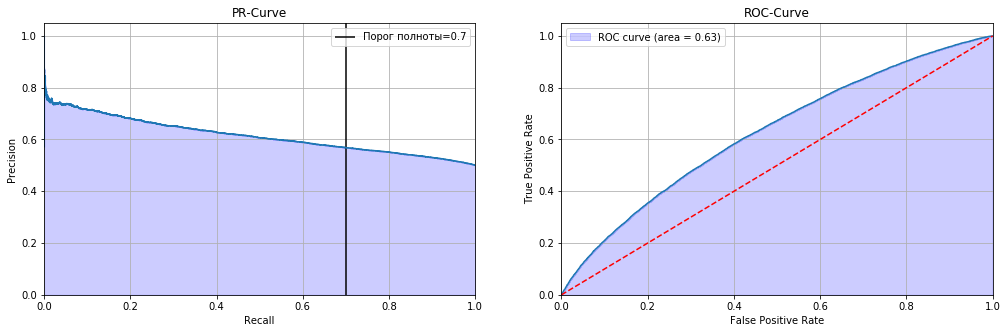

In [10]:
from sklearn import metrics

prediction = train_data @ reg.coef_.T + reg.intercept_ 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

# PR
precision, recall, thresholds_pr = metrics.precision_recall_curve(y_train, prediction)
ax1.plot(recall, precision)
ax1.fill_between(recall, precision, alpha=0.2, color='b')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.grid()
ax1.vlines(0.7, 0, 5, label='Порог полноты=0.7')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('PR-Curve');
ax1.legend()

# ROC
fpr, tpr, thresholds = metrics.roc_curve(y_train, prediction, pos_label=1)
ax2.plot(fpr, tpr)
ax2.plot([0, 1], [0, 1], c='r', ls='--')
ax2.fill_between(fpr, tpr, alpha=0.2, color='b', label='ROC curve (area = %0.2f)' % roc_auc_score(y_train, prediction))
ax2.legend()
ax2.grid()
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_ylim([0.0, 1.05])
ax2.set_xlim([0.0, 1.0])
ax2.set_title('ROC-Curve');


Предположим, что наш алгоритм должен обеспечивать полноту не менее 0.7. Какому порогу бинаризации вероятностей это будет соответствовать? Какую точность (precision) мы получим? Постройте матрицу ошибок для данного порога. Что вы можете сказать о таком алгоритме? (В свободной форме)

In [11]:
print('Порог бинаризации для Recall >= 0.7 будет равен: {:.3f}'.format(thresholds_pr[np.where(recall >= 0.7)[0][-1]]))
print('Precision составит: {:.3f}'.format(precision[np.where(recall >= 0.7)[0][-1]]))

Порог бинаризации для Recall >= 0.7 будет равен: -0.172
Precision составит: 0.569


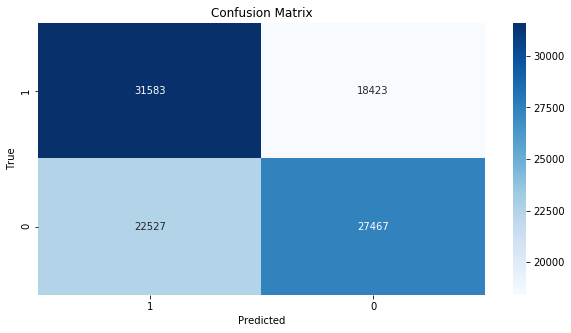

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Получаем матрицу ошибок
matrix = confusion_matrix(y_train, reg.predict(train_data))

# Засовываем матрицу в дф, чтобы подать на вход в seaborn
df_cm = pd.DataFrame(matrix, index = [1, 0],
                  columns = [1, 0])
plt.figure(figsize = (10,5))

# Включаем хитмэп
sn.heatmap(df_cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")

# Фикс неправильного отображения:
# https://github.com/mwaskom/seaborn/issues/1773
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [13]:
print('На тестовой выборке алгоритм показывает следующие результаты:')
print('Precision: {:.3f}'.format(matrix[0][0] / (matrix[0][0] + matrix[0][1])))
print('Recall: {:.3f}'.format(matrix[0][0] / (matrix[0][0] + matrix[1][0])))
print('-'*50)
print('Алгоритм работает лучше случайного. Лучше отличает первый класс от нулевого, чем нулевой от первого, а именно:')
print('Точность распознавания первого класса: {:.3f}'.format(matrix[0][0] / (matrix[0][0] + matrix[0][1])))
print('Точность распознавания нулевого класса: {:.3f}'.format(matrix[1][1] / (matrix[0][1] + matrix[1][1])))


На тестовой выборке алгоритм показывает следующие результаты:
Precision: 0.632
Recall: 0.584
--------------------------------------------------
Алгоритм работает лучше случайного. Лучше отличает первый класс от нулевого, чем нулевой от первого, а именно:
Точность распознавания первого класса: 0.632
Точность распознавания нулевого класса: 0.599


### Задание 4. Кодирование категориальных признаков (1 балл)

Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество моделей. Измерьте время, потребовавшееся на обучение модели.

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Сперва определим, какие столбцы необходимо закодировать
# Чтобы случайно не закодировать всю матрицу данных
all_cols = X_train.columns.values
categorical_features, numeric_features = [], []
for i in all_cols:
    # Всё, что имеет метку cat в названии относим к категориальным признакам
    if i[-3:] == 'cat':
        categorical_features.append(i)
    # Все остальные метки пихаем в числовые
    else:
        numeric_features.append(i)
        
# Строим ПаЙпЛаЙн       
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Не забываем добавить в ремаиндер штуку, чтобы One-Hot-Encoder игнорировал столбцы, которые незя кодировать
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)], remainder='passthrough')

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))])
start = time.time()
_ = clf.fit(X_train, y_train)

print('В результате обучения, точность модели составила: {:.2%}'.format(clf.score(X_test, y_test)))
print('Секунд прошло с момента начала обучения: {:.2f}'.format(time.time() - start))

В результате обучения, точность модели составила: 59.49%
Секунд прошло с момента начала обучения: 8.71


In [15]:
import time
start_time = time.time()

reg = LogisticRegression(random_state=0).fit(X_train, y_train)
print('Средняя точность на тестовых данных составила: {:.2%}'.format(reg.score(X_test, y_test)))
print('Секунд прошло с момента начала обучения: {:.2f}'.format(time.time() - start_time))

Средняя точность на тестовых данных составила: 58.80%
Секунд прошло с момента начала обучения: 8.20


In [16]:
# Вывод: время обучения модели, как и точность предсказания увеличились

### Задание 5. Калибровка вероятностей (4 балла)

В этом задании предлагается самостоятельно разобраться с калибровкой вероятностей. Для этого можно прочитать первый раздел в [конспекте](https://github.com/esokolov/ml-course-hse/blob/master/2018-fall/seminars/sem06.pdf).

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [17]:
def plot_calibration_curve(y_test, preds, printing=True):
    bin_middle_points, bin_real_ratios, bin_num_ones = [], [], []
    n_bins = 20
    segment_width = 1.0 / n_bins
    for i in range(n_bins):
        left = segment_width * i
        right = segment_width * (i + 1)
        
        bin_middle_points.append((right + left) / 2)
        bin_real_ratios.append(
            np.mean(y_test[(preds >= left) & (preds < right)])
        )
        
        # Считаем количество единиц внутри каждого разбиения...
        # понадобится для построения гистограммы.
        amount_of_ones = y_test[(preds >= left) & (preds < right)].sum()
        bin_num_ones.append(amount_of_ones)
        
    if printing:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
        ax1.plot(bin_middle_points, bin_real_ratios, c='r')
        ax1.plot([0, 1], [0, 1], c='grey', ls='--')
        ax1.set_xlabel('Оценка вероятности единицы')
        ax1.set_ylabel('Доля реальных единиц в указанных промежутках')
        ax1.set_title('Калибровочная кривая')
        ax1.grid()

        ax2.scatter(bin_middle_points, bin_num_ones, c='red')
        ax2.plot(bin_middle_points, bin_num_ones, c='black')
        ax2.set_title('Распределение единиц в указанных промежутках')
        ax2.set_ylabel('Количество единиц в указанных промежутках')
        ax2.set_xlabel('Промежутки разбиения, где ширина разбиения = {:.3f}'.format(segment_width))
        ax2.grid()
    
    return (bin_middle_points, bin_real_ratios)
    

Постройте калибровочную кривую для логистической регрессии (на той же самой выборке с тем же самым разбиением — можно использовать уже полученные ранее предсказания). Изучите распределение ответов классификатора (постройте гистограмму с помощью `plt.hist`).

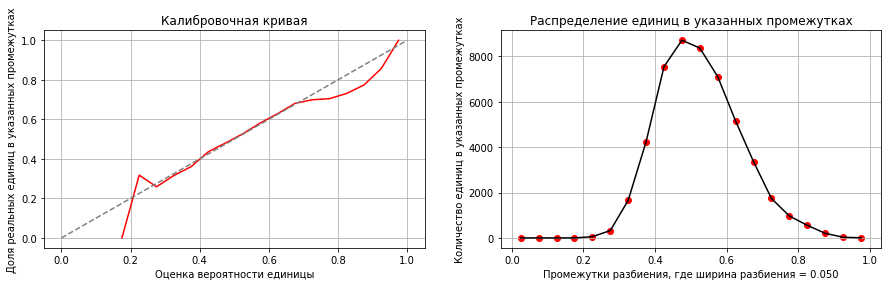

In [18]:
preds = reg.predict_proba(X_test)[:, 1]
before = plot_calibration_curve(y_test, preds)

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей логистической регресии на обучении и постройте с его помощью предсказание для тестовой выборки. Нарисуйте на одном графике калибровочную кривую до и после калибровки. Есть ли улучшения?

In [19]:
from sklearn.calibration import CalibratedClassifierCV
cal = CalibratedClassifierCV(base_estimator=reg, method='isotonic', cv='warn')
cal.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='warn',
                                                         n_jobs=None,
                                                         penalty='l2',
                                                         random_state=0,
                                                         solver='warn',
                                                         tol=0.0001, verbose=0,
                                                  

In [20]:
preds = cal.predict_proba(X_test)[:, 1]
after = plot_calibration_curve(y_test, preds, printing=False)

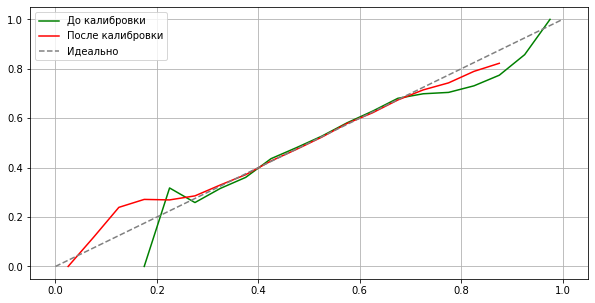

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(before[0], before[1], c='g', label='До калибровки')
plt.plot(after[0], after[1], c='red', label='После калибровки')
plt.plot([0, 1], [0, 1], '--', c='grey', label='Идеально')
plt.legend()
plt.grid()

Что будет, если усилить регуляризацию логистической регресии в $10^3$ раз? Нарисуйте на одном графике калибровочную кривую для сильно регуляризованной регресии и для неё же после калибровки. Есть ли улучшения?

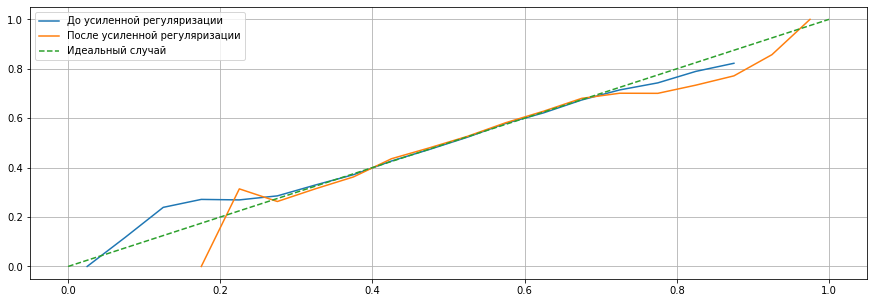

In [22]:
before = after
reg = LogisticRegression(C=1e3).fit(X_train, y_train)
preds = reg.predict_proba(X_test)[:, 1]
after = plot_calibration_curve(y_test, preds, printing=False)

plt.figure(figsize=(15, 5))
plt.plot(before[0], before[1], label='До усиленной регуляризации')
plt.plot(after[0], after[1], label='После усиленной регуляризации')
plt.plot([0, 1], [0, 1], '--', label='Идеальный случай')
plt.legend()
plt.grid()